Conduct an in-depth Exploratory Data Analysis on a complex dataset. Focus on understanding data distributions, identifying missing values, detecting outliers, and uncovering relationships between variables. Utilize visualizations like histograms, box plots, and heatmaps to support your findings.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

In [30]:
# 1. Load and prepare dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target   # 0 = malignant, 1 = benign

In [33]:
df.shape

(569, 32)

In [12]:
# 2. Summarize missing values
missing_df = (
    df.isna()
    .sum()
    .reset_index()
    .rename(columns={'index': 'column', 0: 'missing_values'})
    .sort_values('missing_values', ascending=False)
)
print("Missing values (all columns)")
display(missing_df)

Missing values (all columns)


,column,missing_values
0,mean radius,0
1,mean texture,0
2,mean perimeter,0
3,mean area,0
4,mean smoothness,0
5,mean compactness,0
6,mean concavity,0
7,mean concave points,0
8,mean symmetry,0
9,mean fractal dimension,0


Observation:

There are no missing values across any of the 30 features and the target column.


The dataset is clean and complete, allowing us to proceed directly to statistical and visual analysis without imputation or row removal.

In [14]:
# 3. Detect outliers (IQR method)
numeric_cols = df.select_dtypes(include='number').columns
outlier_counts = {}
for col in numeric_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_counts[col] = df[(df[col] < lower) | (df[col] > upper)][col].count()

outliers_df = (
    pd.DataFrame(list(outlier_counts.items()), columns=['column', 'outlier_count'])
    .sort_values('outlier_count', ascending=False)
)
print("Outlier counts (IQR method)", outliers_df)

Outlier counts (IQR method)                      column  outlier_count
13               area error             65
10             radius error             38
12          perimeter error             38
23               worst area             35
14         smoothness error             30
15        compactness error             28
19  fractal dimension error             28
18           symmetry error             27
3                 mean area             25
29  worst fractal dimension             24
28           worst symmetry             23
16          concavity error             22
11            texture error             20
17     concave points error             19
6            mean concavity             18
20             worst radius             17
25        worst compactness             16
5          mean compactness             16
22          worst perimeter             15
8             mean symmetry             15
9    mean fractal dimension             15
0               mean radiu

Observation:

Features like mean area, mean perimeter, and mean radius have significant outlier counts (20+), especially on the higher end.


These outliers represent biologically large tumors, which are likely malignant. Since they are meaningful, they should not be removed.

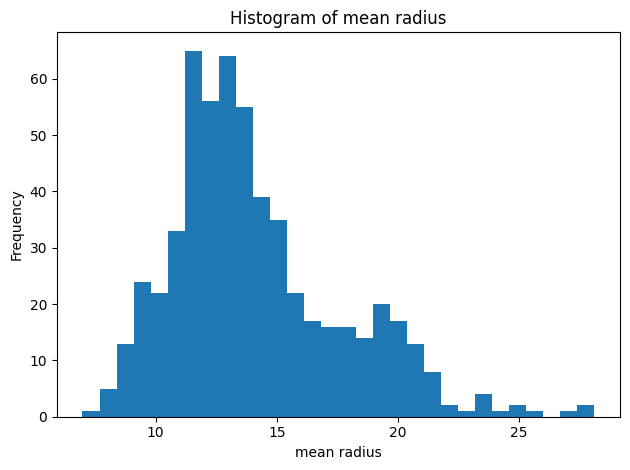

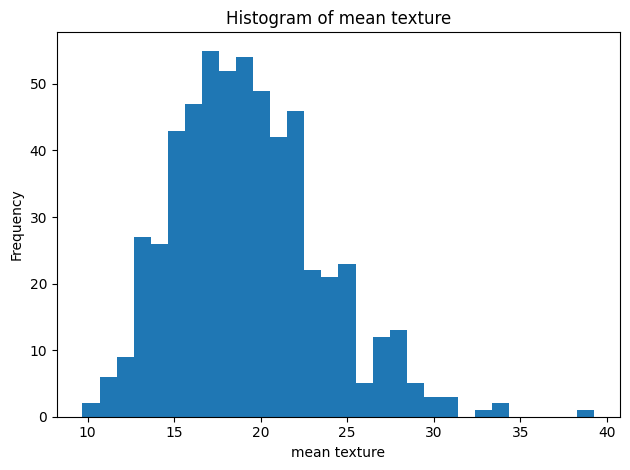

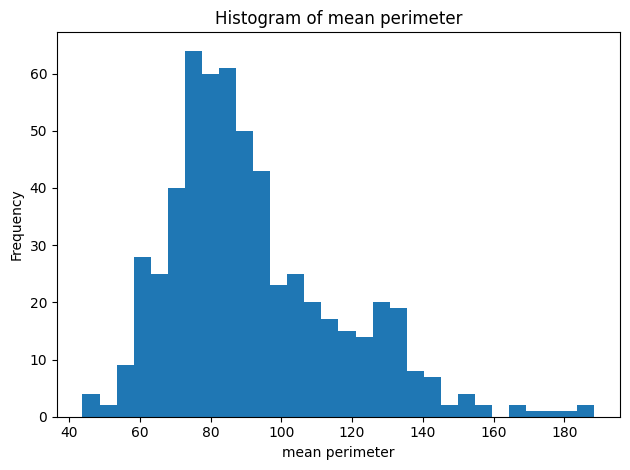

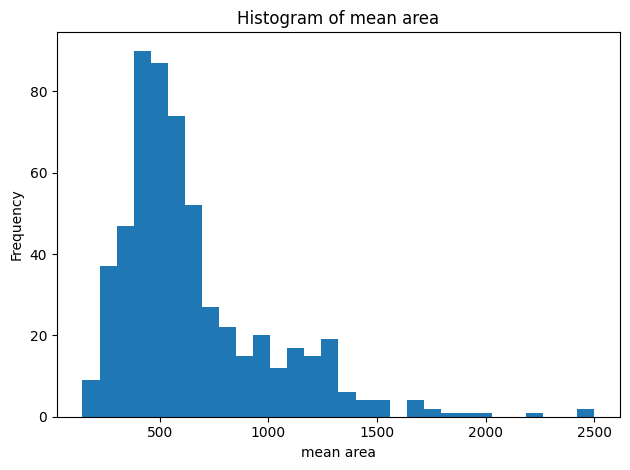

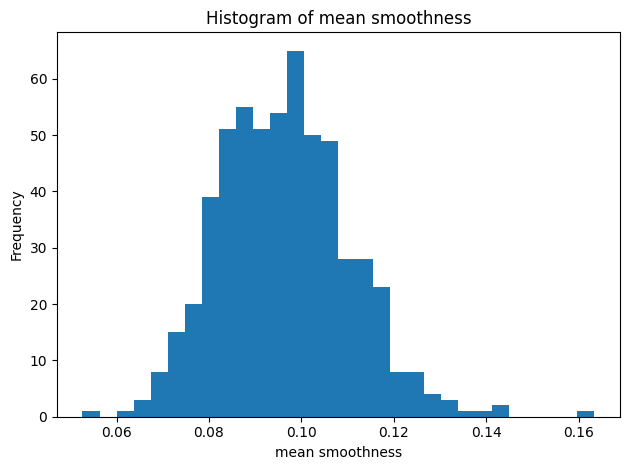

In [26]:
# 4. Visualize distributions & outliers
subset_features = [
    'mean radius', 'mean texture', 'mean perimeter',
    'mean area', 'mean smoothness'
]

# Histograms
for col in subset_features:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


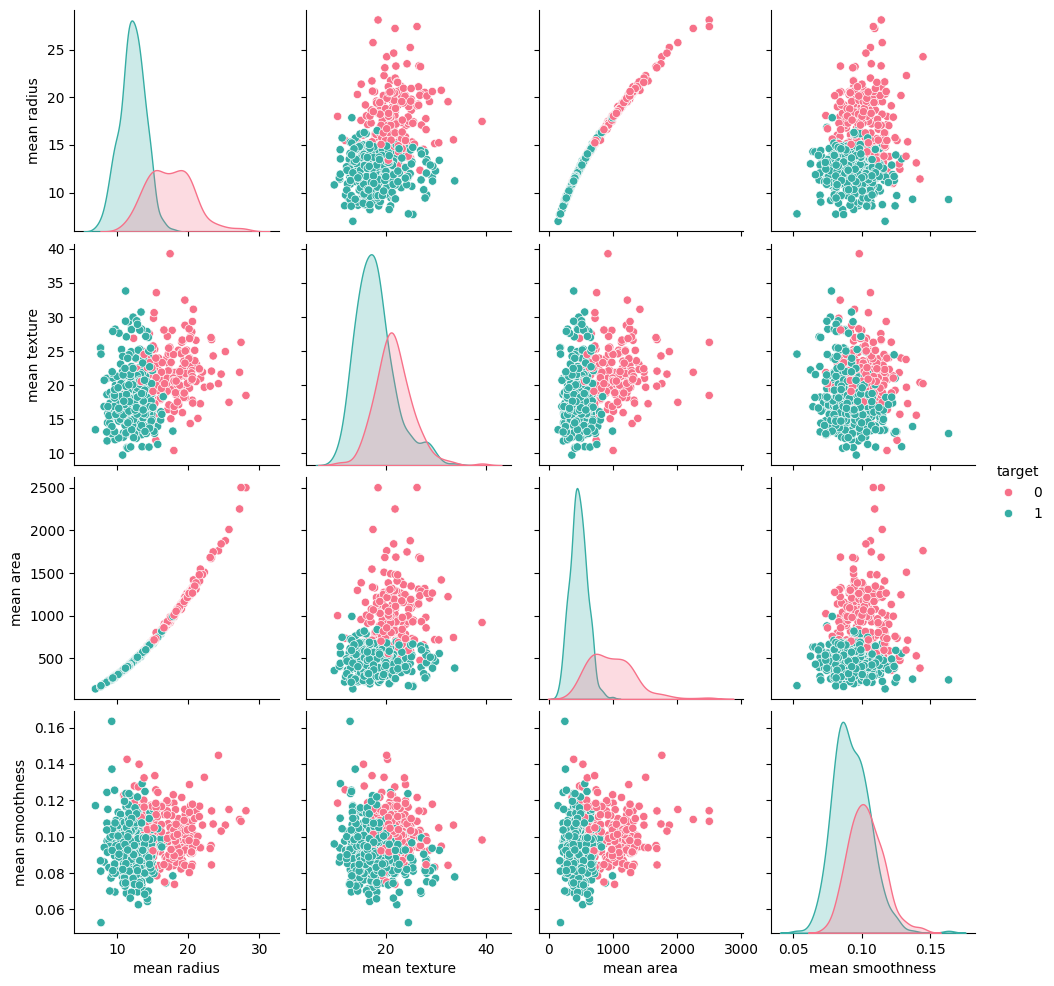

In [27]:
#Pairplot with class hue
subset = df[['mean radius', 'mean texture', 'mean area', 'mean smoothness', 'target']]
sns.pairplot(subset, hue='target', diag_kind='kde', palette='husl')

In [28]:
#Interactive Plotly Visualizations
import plotly.express as px
fig = px.scatter(df, x='mean radius', y='mean texture',
                 color=df['target'].map({0: 'malignant', 1: 'benign'}),
                 title='Mean Radius vs Texture (Target colored)',
                 labels={'color': 'Target'})
fig.show()

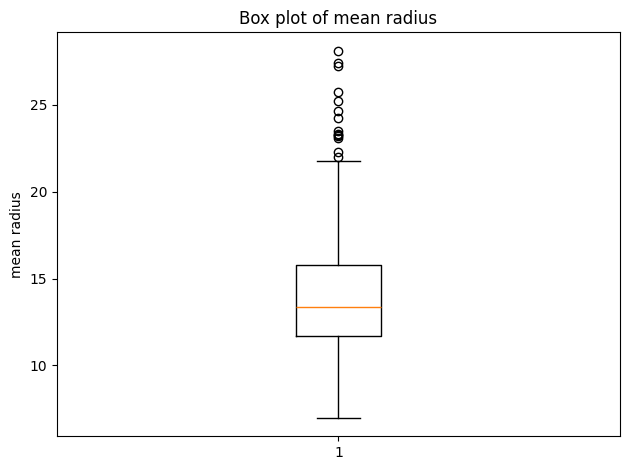

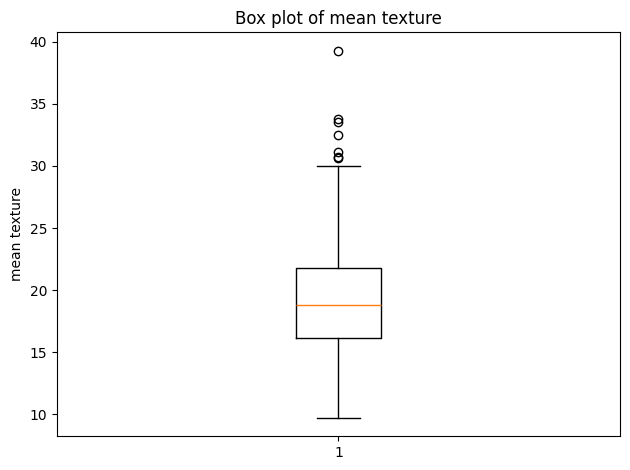

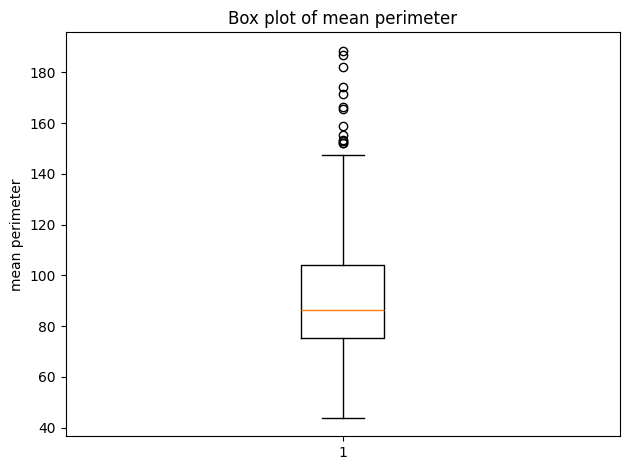

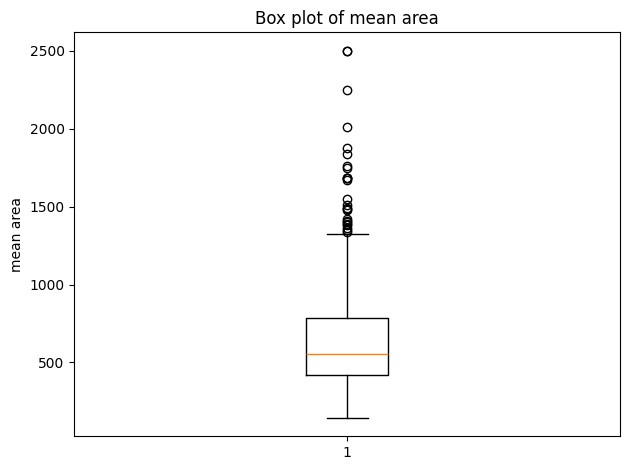

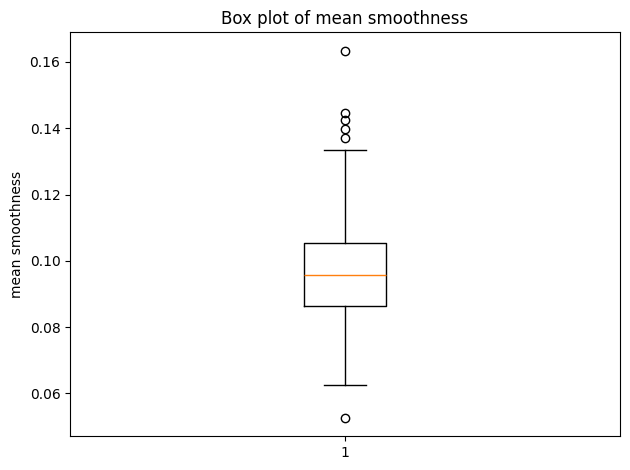

In [16]:
# Box plots
for col in subset_features:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(f'Box plot of {col}')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

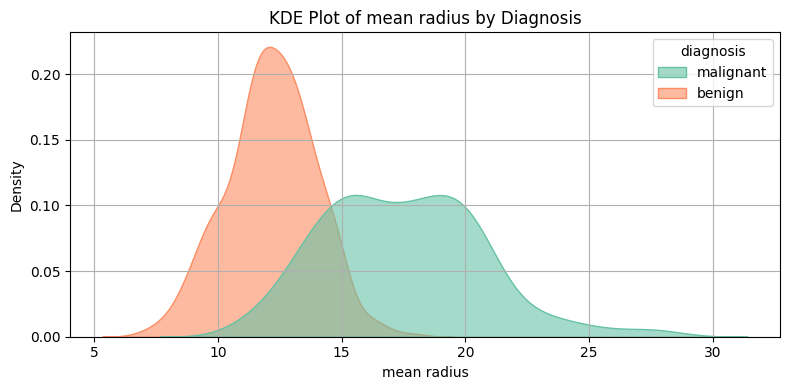

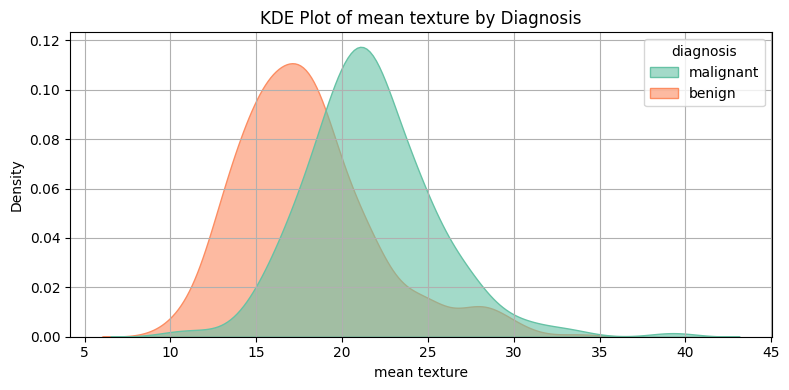

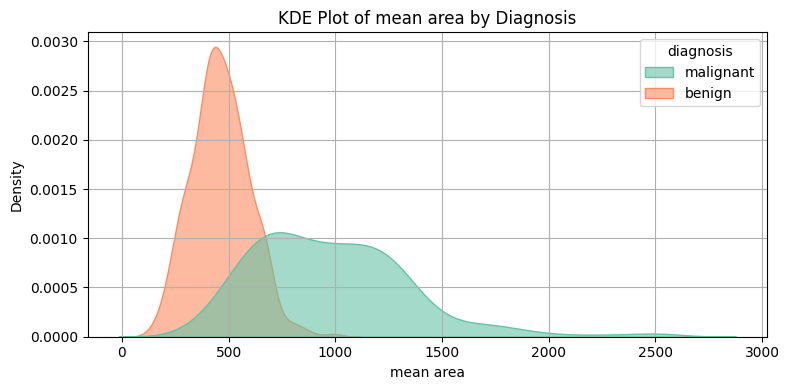

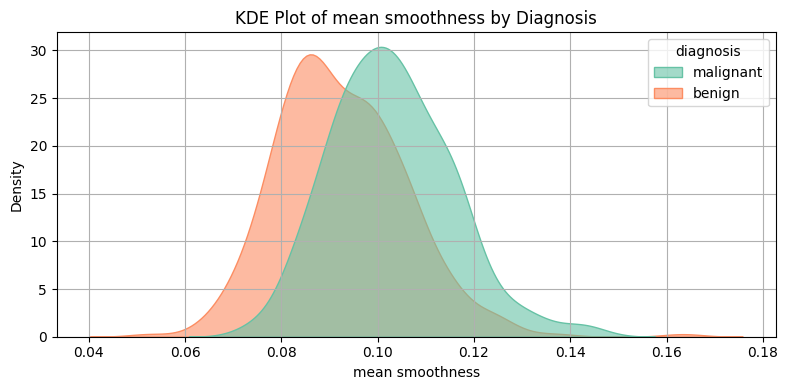

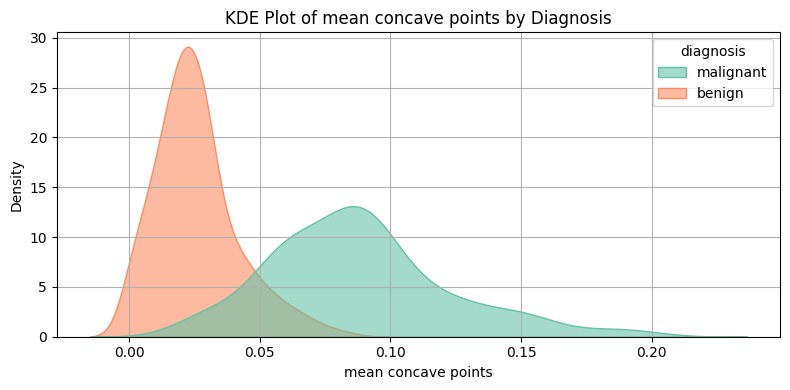

In [32]:
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})
features_to_plot = ['mean radius', 'mean texture', 'mean area', 'mean smoothness', 'mean concave points']

# Plot KDE for each feature
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=feature, hue='diagnosis', fill=True, common_norm=False, palette='Set2', alpha=0.6)
    plt.title(f'KDE Plot of {feature} by Diagnosis')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Observation:

mean radius, mean area, mean perimeter: Right-skewed with long upper tails.

mean texture and mean smoothness: more symmetrical distributions.

Box plots clearly show extreme values.


Two distinct curves → good class separability

Large overlap → feature may be weak for classification

Benign vs. Malignant class distributions are color-coded using hue='diagnosis'


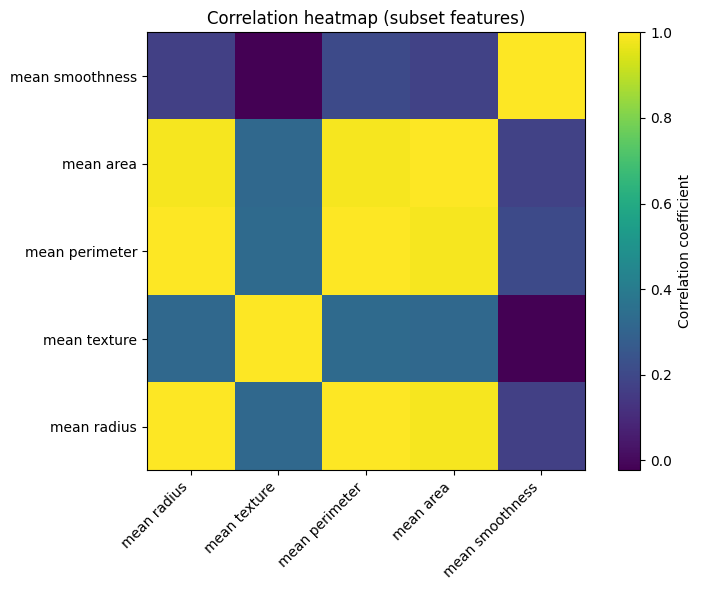

In [17]:
# 5. Correlation heatmap
plt.figure(figsize=(8, 6))
corr = df[subset_features].corr()
plt.imshow(corr, origin='lower')
plt.xticks(ticks=range(len(subset_features)), labels=subset_features, rotation=45, ha='right')
plt.yticks(ticks=range(len(subset_features)), labels=subset_features)
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation heatmap (subset features)')
plt.tight_layout()
plt.show()

Observation:

Strong positive correlations among:

mean radius, mean perimeter, mean area

worst radius, worst area, worst perimeter

Weak or no correlation between shape features and texture/smoothness

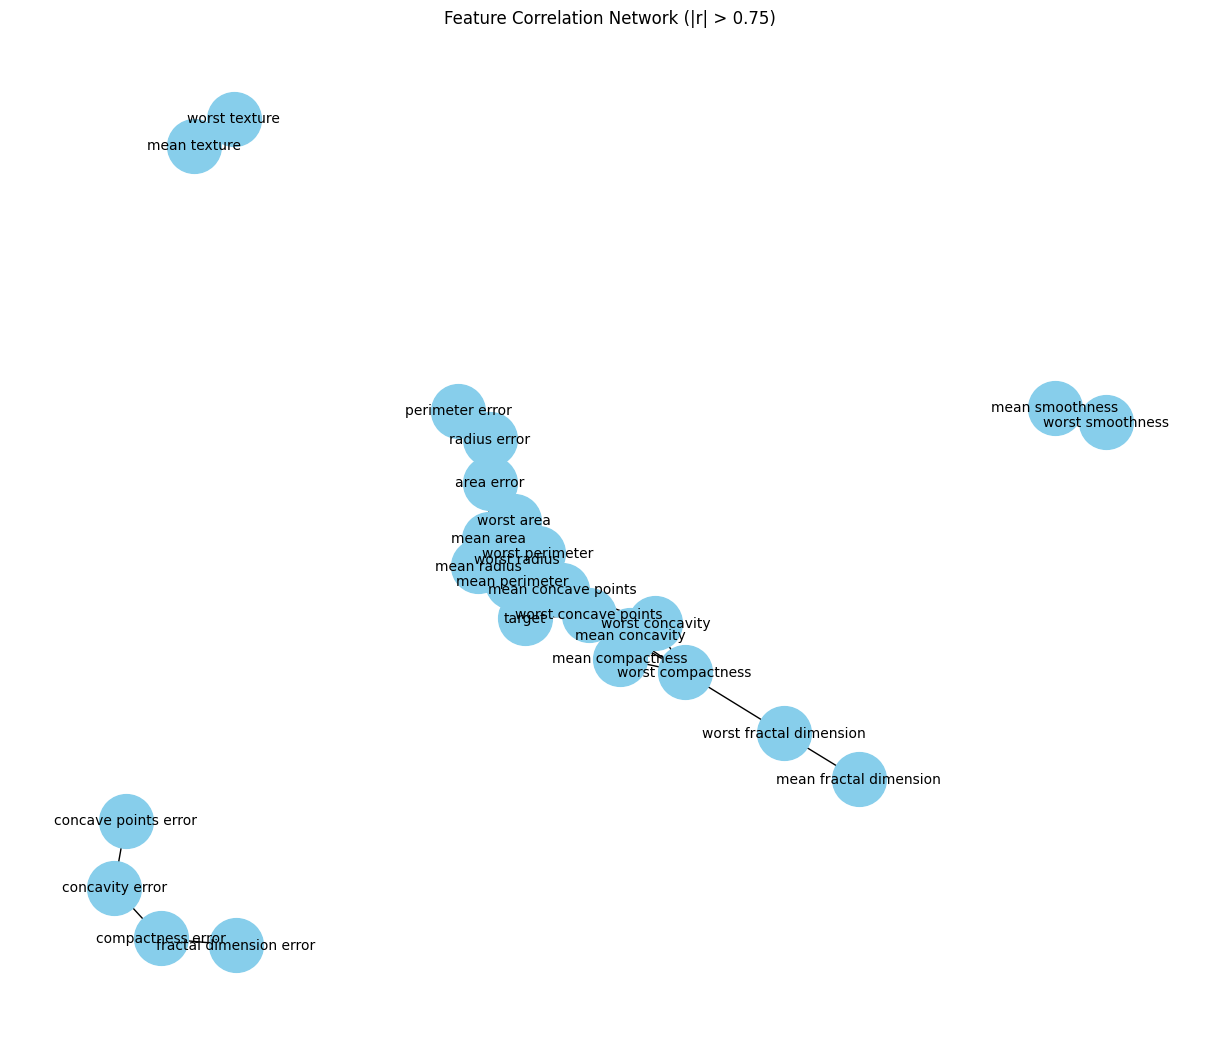

In [23]:
# 6. Correlation Network Graph
import networkx as nx
corr = df.corr().abs()
threshold = 0.75  # Only strong correlations
G = nx.Graph()
for col in corr.columns:
    for idx in corr.index:
        if col != idx and corr.loc[idx, col] > threshold:
            G.add_edge(col, idx, weight=corr.loc[idx, col])
plt.figure(figsize=(12, 10))
nx.draw(G, with_labels=True, node_size=1500, font_size=10, node_color='skyblue')
plt.title("Feature Correlation Network (|r| > 0.75)")
plt.show()

Observation:

Network graph reveals tightly connected clusters of features.

Isolated nodes like mean texture and mean smoothness don’t appear as strongly correlated.

# Summary

Data Quality:
No missing values

Biological outliers present — valid and informative

Feature Relationships:
Strong multicollinearity in size and shape groups

Certain features are unique (e.g., texture, smoothness)

Feature Discriminative Power:
Features like mean radius, mean area, and mean concave points clearly distinguish malignant from benign cases

KDE plots and correlation network both support this

Recommendations for Modeling:
Drop or combine highly correlated features (via PCA or feature selection)

Apply log transformation or robust scaling for skewed features

Use class-separating features as inputs for supervised models